# **Exploring Fully Connected Layers**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**


In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import summary libraries for model information
from torchsummary import summary

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
# use GPU if available
device = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

In [4]:
# Creating Gaussian Blurs with different widths
nPerClass=1000
imgSize=91

x=np.linspace(-4,4,imgSize)
X,Y=np.meshgrid(x,x)

# the two widths (arbitary units {a.u.})
widths=[1.8,2.4]

# initialize tensors containing images and labels
images=tr.zeros(2*nPerClass,1,imgSize,imgSize)
labels=tr.zeros(2*nPerClass)

print(labels.shape)

for i in range(2*nPerClass):

    # create the gaussian with random centers
    ro=2*np.random.randn(2) # ro-> random offset
    G=np.exp(-((X-ro[0])**2+(Y-ro[1])**2)/(2*widths[i%2]**2))

    # and add noise
    G=G+np.random.randn(imgSize,imgSize)/5

    # add to tensor
    images[i,:,:,:]=tr.Tensor(G).view(1,imgSize,imgSize)
    labels[i]= i%2

labels = labels[:,None] # makes labels shape from torch.Size([2000]) to torch.Size([2000,1])
print(labels.shape)

torch.Size([2000])
torch.Size([2000, 1])


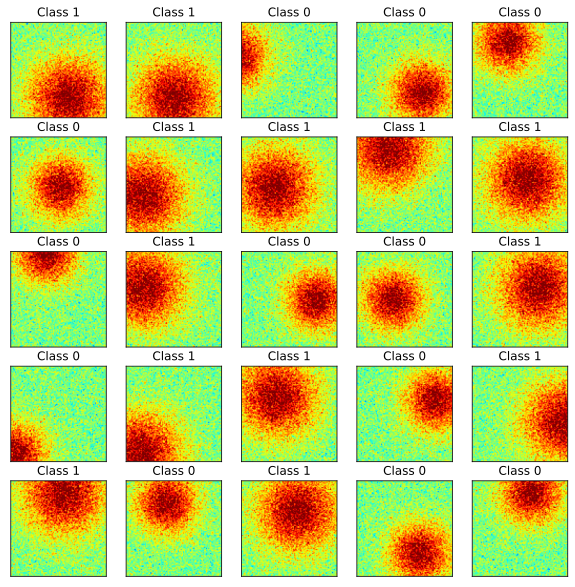

In [5]:
# visualize some images
fig,axs=plt.subplots(5,5,figsize=(10,10))

for i,ax in enumerate(axs.flatten()):
    whichpic=np.random.randint(2*nPerClass)
    G=np.squeeze(images[whichpic,:,:])
    ax.imshow(G,vmin=-1,vmax=1,cmap="jet")
    ax.set_title('Class %s'%int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [6]:
# Create train/test groups using Dataloader

# step 2: use scikit-learn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(images,labels,test_size=0.1)

# step 3: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)

# step 4: translate into dataloader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [7]:
# check size (should be images x channels x width x height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


In [8]:
def outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,outChannels):
    Nh=int(np.floor((imgSize[0]+2*paddingSize[0]-kernelSize[0])/strideSize[0]))+1
    Nw=int(np.floor((imgSize[1]+2*paddingSize[1]-kernelSize[1])/strideSize[1]))+1
    return outChannels,(Nh,Nw),(int(Nh//poolSize[0]),int(Nw//poolSize[1]))

def fcInput(imgSize,inChannels):
    return int(imgSize[0]*imgSize[1]*inChannels)

In [9]:
# Create the DL model
def createNet(fc2_nodes,lr=0.001):
    convOutChannels=[6,4]
    imgSize=(91,91)
    kernelSize=(3,3)
    strideSize=(1,1)
    paddingSize=(1,1)
    poolSize=(2,2)
    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # conv 1
            self.conv1=nn.Conv2d(1,convOutChannels[0],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp1=outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,convOutChannels[0])
            
            # conv 2
            self.conv2=nn.Conv2d(convOutChannels[0],convOutChannels[1],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp2=outConvPoolSize(self.outcp1[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[1])

            # fc1
            self.fci=fcInput(self.outcp2[2],self.outcp2[0])
            self.fc1=nn.Linear(self.fci,2*fc2_nodes)

            # fc2
            self.fc2=nn.Linear(fc2_nodes*2,fc2_nodes)

            # output
            self.output=nn.Linear(fc2_nodes,1)

        def forward(self,x):
            # first conv-pool set
            conv1act=F.relu(self.conv1(x))  
            x=F.avg_pool2d(conv1act,poolSize)

            # second conv-pool set
            conv2act=F.relu(self.conv2(x))  
            x=F.avg_pool2d(conv2act,poolSize)
            

            # FNN part
            x=x.reshape(x.shape[0],-1)
            x=F.relu(self.fc1(x))
            x=F.relu(self.fc2(x))
            x=self.output(x)
        
            return x,conv1act,conv2act

    # create the model instance
    net=GaussNet()

    # loss function
    lossfun=nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = tr.optim.Adam(net.parameters(),lr=lr)

    return net,lossfun,optimizer

In [10]:
# test the model with one batch
net,lossfun,optimizer=createNet(25)

X,y = next(iter(train_loader))
yHat,featmap1,featmap2=net(X)

# check size of output
print('\nPredicted Category')
print(yHat.shape)
print('\nFeature maps after conv1')
print(featmap1.shape)
print('\nFeature maps after conv2')
print(featmap2.shape)


# now let's compute the loss
loss=lossfun(yHat,y)
print(' ')
print('Loss: ')
print(loss)


Predicted Category
torch.Size([32, 1])

Feature maps after conv1
torch.Size([32, 6, 91, 91])

Feature maps after conv2
torch.Size([32, 4, 45, 45])
 
Loss: 
tensor(0.7017, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [11]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
            Linear-3                   [-1, 50]          96,850
            Linear-4                   [-1, 25]           1,275
            Linear-5                    [-1, 1]              26
Total params: 98,431
Trainable params: 98,431
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.38
Estimated Total Size (MB): 0.85
----------------------------------------------------------------


In [12]:
# Create a function that trains the model

def trainModel(fc2_nodes,n_epochs=10):
    # create a new model
    net,lossfun,optimizer=createNet(fc2_nodes)

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = tr.zeros(n_epochs)
    testLoss = tr.zeros(n_epochs)
    trainAcc = tr.zeros(n_epochs)
    testAcc = tr.zeros(n_epochs)

    # loop over epochs
    for epochi in range(n_epochs):

        # loop over training data batches
        batchLoss=[]
        batchAcc=[]

        for X,y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat=net(X)[0]
            loss=lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchAcc.append(tr.mean(((yHat>0.5)==y).float()).item())

            # end of batch loop ...

        # and get the average losses across the batches
        trainLoss[epochi]=np.mean(batchLoss)
        trainAcc[epochi]=100*np.mean(batchAcc)

        # test accuracy
        X,y=next(iter(test_loader))
        # push data to GPU
        X = X.to(device)
        y = y.to(device)
        with tr.no_grad(): # deactivates autograd
            yHat=net(X)[0]
            loss=lossfun(yHat,y)

        # compare the following really long lines of code to the training accuracy lines
        testLoss[epochi]=loss.item()
        testAcc[epochi]=100*tr.mean(((yHat>0)==y).float()).item() # doubt here

    # end of epochs

    # function output
    return trainLoss,testLoss,trainAcc,testAcc,net

In [13]:
# Run the model and show the result (it takes around 5 mins on the CPU (Ryzen 7 5700u {16GB RAM}))
# Takes around 51 seconds on T4 GPU on google colab.

# specify number of hidden units 
numberOfLinearUnits=np.round(np.linspace(5,500,20))

# initialize the results matrix
results=np.zeros((len(numberOfLinearUnits),4))

for i,nunits in enumerate(numberOfLinearUnits):
    trainLoss,testLoss,trainAcc,testAcc,net=trainModel(int(nunits))
    results[i,:]=[trainLoss[-1],testLoss[-1],trainAcc[-1],testAcc[-1]]
    print(f"{i+1}/{len(numberOfLinearUnits)} complete")

1/20 complete
2/20 complete
3/20 complete
4/20 complete
5/20 complete
6/20 complete
7/20 complete
8/20 complete
9/20 complete
10/20 complete
11/20 complete
12/20 complete
13/20 complete
14/20 complete
15/20 complete
16/20 complete
17/20 complete
18/20 complete
19/20 complete
20/20 complete


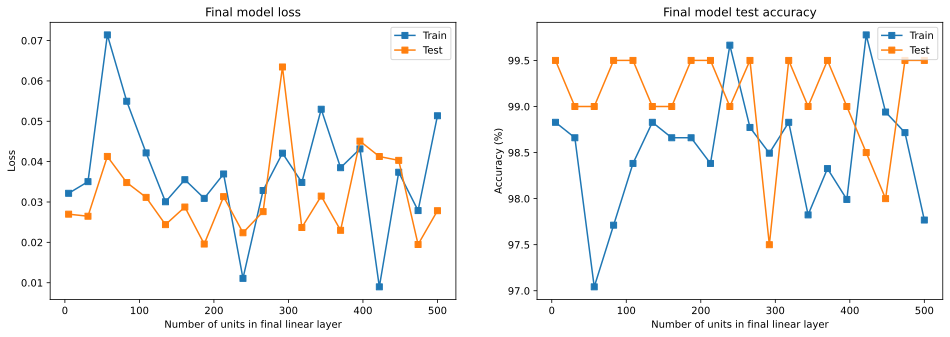

In [15]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(numberOfLinearUnits,results[:,:2],'s-')
ax[0].set_xlabel('Number of units in final linear layer')
ax[0].set_ylabel('Loss')
ax[0].set_title('Final model loss')
ax[0].legend(['Train','Test'])

ax[1].plot(numberOfLinearUnits,results[:,2:],'s-')
ax[1].set_xlabel('Number of units in final linear layer')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Final model test accuracy')
ax[1].legend(['Train','Test'])

plt.show()